In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [22]:
import numpy as np
import pandas as pd

In [23]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [25]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [26]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [27]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [28]:
# Save references to each table
# Create our session (link) from Python to the DB
session = Session(engine)
Measurement = Base.classes.measurement
Station = Base.classes.station
inspector = inspect(engine)

In [29]:
#preview Measurement (first row)
firstmeasurement = session.query(Measurement).first()
firstmeasurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e30d0894e0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1}

In [30]:
#preview Station (first row)
firststation = session.query(Station).first()
firststation.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e30d089b38>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [31]:
#Identify datatype in table Measurement
columns_measurement = inspector.get_columns('Measurement')
for measure in columns_measurement:
    print(measure['name'], measure["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [32]:
#Identify datatype in table Station
columns_station = inspector.get_columns('Station')
for station in columns_station:
    print(station['name'], station["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [33]:
#Last date in Measurement table
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [34]:
#First date in Measurement table
session.query(Measurement.date).first()

('2010-01-01')

# Exploratory Climate Analysis

In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Calculate date 12 months from most recent date (queried above)
last12months = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
#Derive average precipitation per day across all stations, removing NULL values
precipitation_last12months = session.query(Measurement.date, func.avg(Measurement.prcp)).\
filter(Measurement.date >= last12months).\
filter(Measurement.prcp != 'None').\
group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_last12months, columns=['date', 'prcp'])
precipitation_df = precipitation_df.set_index("date")

# Sort the dataframe by date
precipitation_df.sort_values("date").head()

,prcp
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


In [36]:
precipitation_df.dtypes

prcp    float64
dtype: object

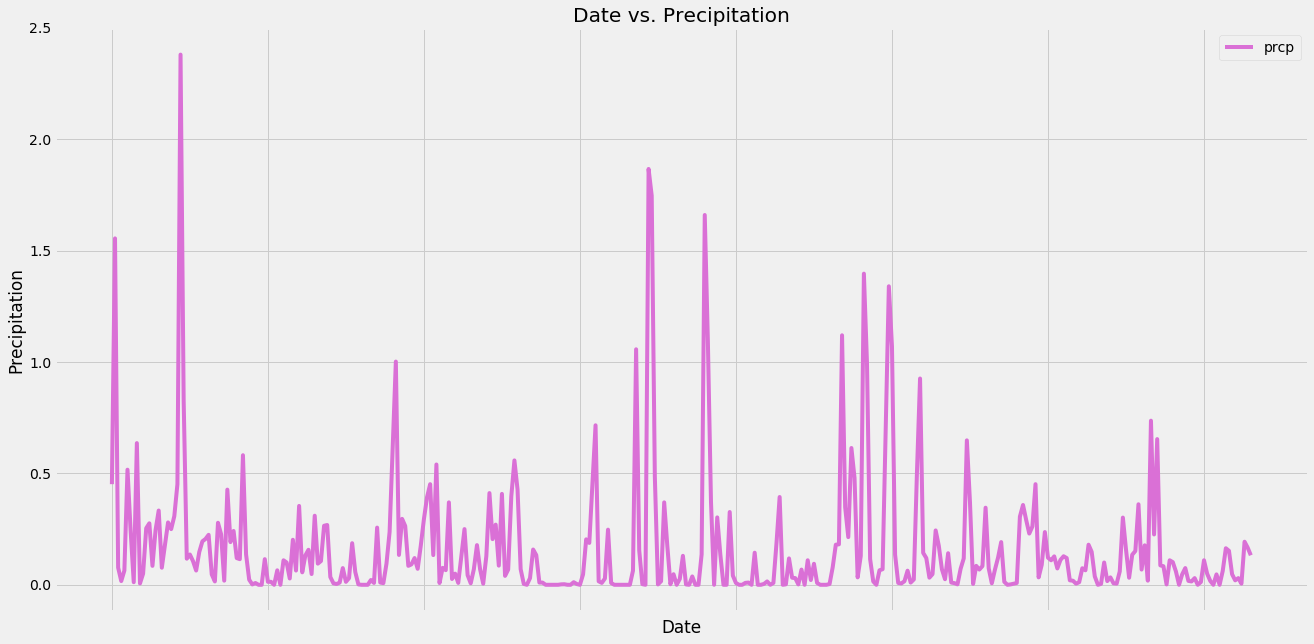

In [37]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(kind="line",
               x=None,
               y="prcp", 
               grid=True, 
               figsize=(20,10),
               color="orchid",
               title="Date vs. Precipitation")

plt.xlabel("Date")
plt.ylabel("Precipitation")

plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [40]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [43]:
#Examine data to check for duplicates or data issues...none found.
session.query(Station.name).all()

[('WAIKIKI 717.2, HI US'),
 ('KANEOHE 838.1, HI US'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('PEARL CITY, HI US'),
 ('UPPER WAHIAWA 874.3, HI US'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('WAIHEE 837.5, HI US'),
 ('HONOLULU OBSERVATORY 702.2, HI US'),
 ('MANOA LYON ARBO 785.2, HI US')]

In [57]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Station.name, Station.id, func.count(Measurement.id).label("totalbystation")).\
filter(Measurement.station == Station.station).\
group_by(Station.name).\
order_by("totalbystation desc").all()

#For ease of viewing, convert to dataframe
active_stations_df = pd.DataFrame(active_stations)
active_stations_df

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\sqlalchemy\sql\compiler.py:643: SAWarning: Can't resolve label reference 'totalbystation desc'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


,name,id,totalbystation
0,"WAIHEE 837.5, HI US",7,2772
1,"WAIKIKI 717.2, HI US",1,2724
2,"KANEOHE 838.1, HI US",2,2709
3,"WAIMANALO EXPERIMENTAL FARM, HI US",6,2669
4,"MANOA LYON ARBO 785.2, HI US",9,2612
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",3,2202
6,"HONOLULU OBSERVATORY 702.2, HI US",8,1979
7,"PEARL CITY, HI US",4,1372
8,"UPPER WAHIAWA 874.3, HI US",5,511


In [86]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperatures = session.query(Station.id.label("station_id"), 
                             func.round(func.min(Measurement.tobs)).label("min_temp"), 
                             func.round(func.max(Measurement.tobs)).label("max_temp"), 
                             func.round(func.avg(Measurement.tobs)).label("avg_temp")).\
filter(Measurement.station == Station.station).\
group_by("station_id").all()

#For ease of viewing, convert to dataframe
temperatures_df = pd.DataFrame(temperatures).set_index("station_id")
temperatures_df

,min_temp,max_temp,avg_temp
station_id,,,
1,56.0,87.0,75.0
2,59.0,85.0,73.0
3,58.0,85.0,75.0
4,58.0,87.0,75.0
5,58.0,83.0,73.0
6,56.0,85.0,75.0
7,54.0,85.0,72.0
8,53.0,87.0,72.0
9,58.0,84.0,71.0


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [93]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
str = ["012", "345"]
print(str*2)*2

['012', '345', '012', '345']


TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
